# 1 - Getting Started

_Welcome to GPlately!_

GPlately uses object-oriented programming to make life simple. In this notebook we will explore some of the main objects you will use:

- `PlateReconstruction` - reconstruct features, tesselate mid ocean ridges, subduction zones
- `Points` - partition points onto plates, rotate back through time
- `Raster` - read in NetCDF grids, interpolation, resampling.
- `PlotTopologies` - one stop shop for plotting ridges, trenches, subduction teeth
- `DataServer` - another one stop shop for downloading .rot, .gpml, .shp and .nc files for the objects above!

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Making plate reconstructions

We simply supply a rotation model, plate topologies, and static polygons to initialise a plate reconstruction model. You can download these files into your machine's cache using GPlately's `DataServer` object.

In [2]:
# Call GPlately's DataServer object (from the download.py module) and request data from the Müller et al. 2019 study
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Now let's find the subduction zones and mid-ocean ridges at 10 Ma.

In [3]:
time = 10

# these bundle a lot of information - check PTT docs for more info
subduction_data = model.tesselate_subduction_zones(time, ignore_warnings=True)
ridge_data = model.tesselate_mid_ocean_ridges(time, ignore_warnings=True)

## Plotting

The `PlotTopologies` function injests the plate model we have defined as well as the coastlines, continents, and COB. It computes all of the plate topologies for a given reconstruction time.

This object has been designed to work specifically with `cartopy`. Define your figure and supply your axes to these plotting routines. Some common favourites include:

- coastlines
- continents
- ridges and transforms
- trenches
- subduction teeth (!!)
- netCDF grids
- plate motion vectors

You can still supply optional keywords as you normally would.

In [4]:
time = 10

# Obtain features for the PlotTopologies object with DataServer
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

# Download all Muller et al. 2019 netCDF age grids with DataServer
agegrid = gdownload.get_age_grid(time)

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


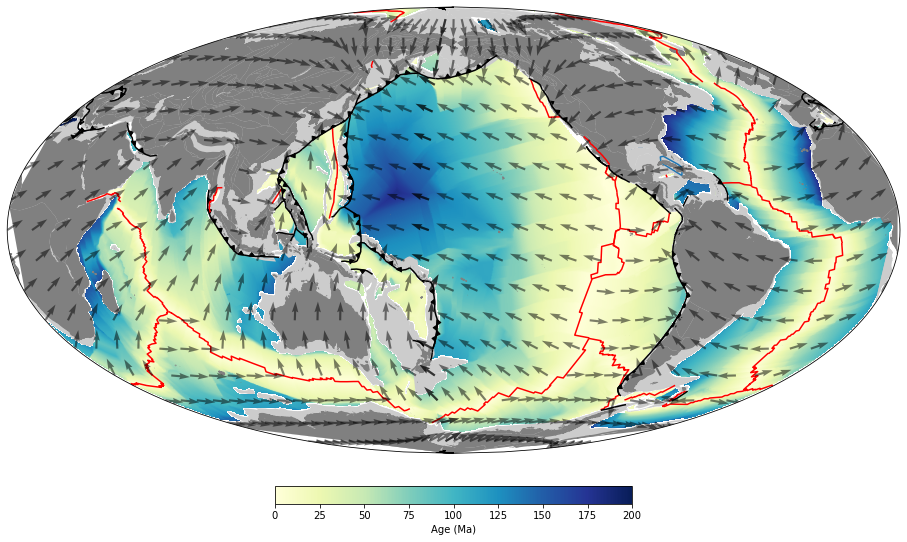

In [5]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

/Users/laurenilano/opt/miniconda3/envs/gplatelyyy/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


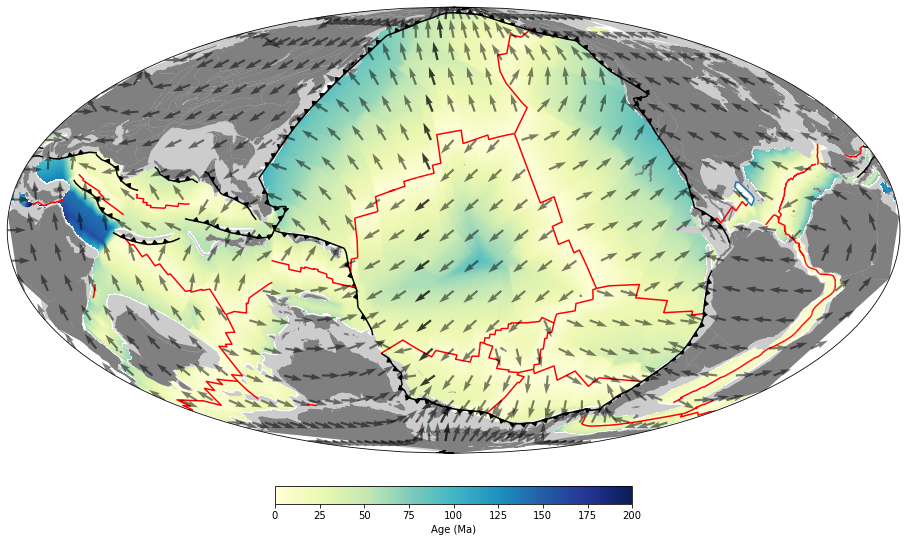

In [6]:
# update the time to regenerate topologies
time = 100
gplot.time = time
agegrid = gdownload.get_age_grid(time)

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

## Working with points

Now that we have defined our reconstruction object, we can reconstruct point data.

In [7]:
pt_lons = np.array([140., 150., 160.])
pt_lats = np.array([-30., -40., -50.])

gpts = gplately.Points(model, pt_lons, pt_lats)

vel_x, vel_y = gpts.plate_velocity(0)
vel_mag = np.hypot(vel_x, vel_y)

print("average point velocity (cm/yr)", vel_mag)

average point velocity (cm/yr) [6.38389518 5.71007208 5.06602802]


Plot their position from `time=0` to `time=20`

In [8]:
rlons = np.empty((21, pt_lons.size))
rlats = np.empty((21, pt_lons.size))


for time in range(0, 21):
    rlons[time], rlats[time] = gpts.reconstruct(time)

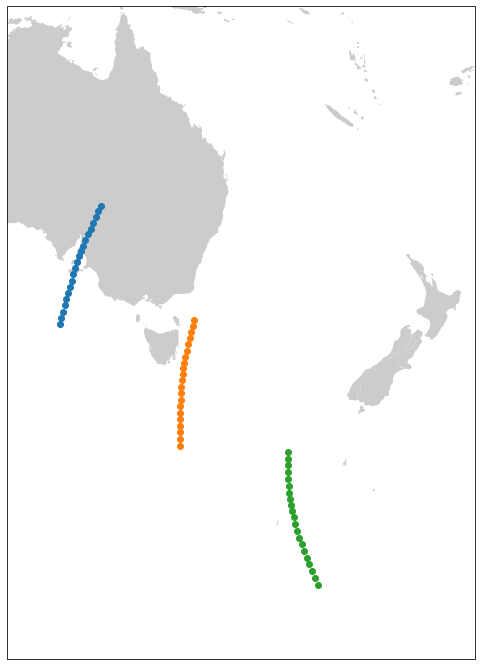

In [9]:
gplot.time = 0 # present day

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mercator(190))
ax1.set_extent([130,180,-60,-10])

gplot.plot_coastlines(ax1, color='0.8')

for i in range(0, len(pt_lons)):
    ax1.plot(rlons[:,i], rlats[:,i], 'o', transform=ccrs.PlateCarree())

## Rasters

You can initialise a `Raster` object by passing the `PlateReconstruction` model and pointing to a raster (either a NetCDF file path or a regular numpy array). The `data` attribute stores the raster data as a 2D numpy array.

In [10]:
time = 100

graster = gplately.Raster(model, array=agegrid)

<GeoAxesSubplot:>

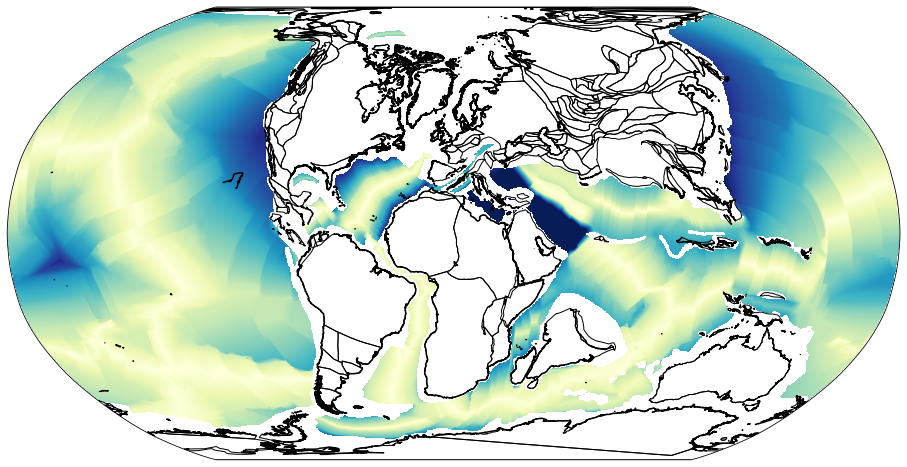

In [11]:
gplot.time = time

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
gplot.plot_grid(ax1, graster.data, cmap='YlGnBu', vmin=0, vmax=100)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='none')

There are a bunch of routines such as,

- filling masked (NaN) regions
- interpolation
- resampling

In-place operations can be achieved using `overwrite=True` which will update the internal data structures.

<GeoAxesSubplot:>

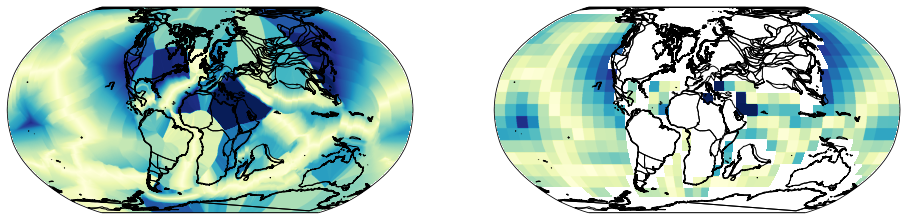

In [12]:
filled_data = graster.fill_NaNs(overwrite=False)
downsampled_data = graster.resample(spacingX=10, spacingY=10, overwrite=False)



fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
gplot.plot_grid(ax1, filled_data, cmap='YlGnBu', vmin=0, vmax=100)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='none')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
gplot.plot_grid(ax2, downsampled_data, cmap='YlGnBu', vmin=0, vmax=100)
gplot.plot_coastlines(ax2, edgecolor='k', facecolor='none')